In [1]:
import random
import time

### Utility functions for graph import
Place graph in the same directory as this ipynb for access.
Simply call the function withe the file name and a adjacency list graph representation will be returned. 

Input files for graphs should follow the structure to indicate an edge.
<br><br>
toNode&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fromNode
<br>
nodeNum&nbsp;&nbsp;&nbsp;&nbsp;nodeNum

In [2]:
# Parses information from the roadNet-CA.txt format. Random graph generated from GraphGenerator.ipynb also follows this format.
# First four lines are lines that describe the graph.
# After that, all inputs follow the format: toNode\tfromNode
def read_graph_file(file_name):
    graph = {}
    with open(file_name, "r") as f:
            f.readline()
            f.readline()
            f.readline()
            f.readline()
            line = f.readline().strip()
            while (line != ""):
                fromNode, toNode = line.split("\t")
                fromNode = int(fromNode)
                toNode = int(toNode)
                if fromNode not in graph:
                    graph[fromNode] = [toNode]
                else:
                    graph[fromNode].append(toNode)
                line = f.readline().strip()
    return graph

# Randomly num samples of hospital nodes from a given graph 
def generate_hospital_nodes(graph, num = 5):
    length = len(graph)
    nodes = list(graph.keys())
    return random.sample(nodes, num)

# Read nodes stored in a file
# First line indicates number of nodes: #num
# Subsequent num lines indicate the nodes to identify as a hospital
def read_hospital_nodes(filename):
    hospitals = []
    with open(filename, "r") as f:
        f.readline()
        line = f.readline().strip()
        while (line != ""):
            hospitals.append(int(line))
            line = f.readline().strip()
    return hospitals

In [3]:
# Read the road network graph
graph = read_graph_file("roadNet-CA.txt")

In [4]:
# Read the road network graph randomly generated hospital nodes.
filename = "file2.txt"
# Function is provided if you want to randomize the hospital nodes.
# hospitals = generate_hospital_nodes(graph)
hospitals = read_hospital_nodes(filename)
hospitals

[3, 10, 19, 34]

In [5]:
# Converts each datapoint to a line by line format for output as a list
def write_to_file_format_a_b(data):
    # Expected data should take the format
    # {node number: [nearest_path]}
    return_list = []
    for key, value in data.items():
        if not value:
            continue
        else:
            temp_list = "->".join((str(x) for x in value))
            return_list.append(f"{key}\t{len(value)-1}\t{temp_list}\n" )
            
    return return_list

In [6]:
# Converts each datapoint to a line by line format for output as a list
def write_to_file_format_c_d(data, k = 1):
    # Expected data should take the format
    # {node number : {nearest_hospital: distance, 2nd_nearest_hospital: distance..., kth_nearest_hospital: distance}}
    return_list = []
    for node, results in data.items():
        if not results:
            return_list.append(f"Node {node} not connected to any hospitals!\n")
            continue
        i=0
        for hosp,dist in results.items():
            return_list.append(f"No.{i+1} nearest hospital for node[{node}]: {hosp}\tDistance: {dist}\n")
            i+=1
        for j in range(i, k):
            return_list.append(f"No {j+1} nearest hospital for node[{node}].\n")
    return return_list

In [7]:
# Basic BFS for Graph Search with multiple targets. Solves (a) and (b)

### Implements Breadth-first Floodfill algorithm. Allows for BFS with multiple targets. Solves task (a) and (b)
class NearestTargetGraph:
    def __init__(self, graph = None):
        # Expected {node : list of connections}
        self.graph = graph if graph else {}
    
    # Method for adding an edge to the graph if creating graph from scratch.
    def add_edge(self, u:int ,v:int):
        if u not in self.graph:
            self.graph[u] = [v]
        else:
            self.graph[u].append(v)
    
    # Applying Floodfill BFS. Average time complexity of O(|V| + |E|)
    def bfs(self, targets):
        #### Pre-processing. Time complexity of O(|V|)
        
        # Graph of {node : [current_node, previous_node, ..., hospital_node]}
        self.path_to_nearest_hospital = {node:[] for node in self.graph}
        # Use a hashmap to track visited for faster lookup times.
        visited = {node:False for node in self.graph}
        
        # Queue is a list that holds the path travelled so far from a specific hospital node.
        # Path follows the format [current_node, prev_node, ... , hospital_node
        queue = []
        
        for target in targets:
            queue.append([target])
            visited[target] = True
            self.path_to_nearest_hospital[target] = [target]
        
        ### Searching. Average time complexity of O(|V| + |E|)
        while queue:
            path = queue.pop(0)
            curr_node = path[0]
                        
            # Search all neighbouring nodes to see if we can traverse them
            for child_node in self.graph[curr_node]:
                # If the node has been visited, skip to prevent overlap. 
                # If it is visited, indicative that there is a nearer hospital to this node than the hospital this path originated from
                # If not, store the path to the next node.
                if not visited[child_node]:
                    new_path = list(path)
                    new_path.insert(0, child_node)
                    queue.append(new_path)
                    visited[child_node] = True
                    self.path_to_nearest_hospital[child_node] = list(new_path)

In [8]:
# Run the first algorithm on the California Road Network graph to solve task a) and b), and stores it to a text file.


nearest_hospital_graph_ab = NearestTargetGraph(graph)
nearest_hospital_graph_ab.bfs(hospitals)

In [9]:
## Store output file for road network task (a) and (b)
with open("roadCA_taskAB.txt", "w") as f:
    f.writelines("fromNode\tdistance\tpath\n")
    f.writelines(write_to_file_format_a_b(nearest_hospital_graph_ab.path_to_nearest_hospital))

In [10]:
### Implements Breadth-first Floodfill algorithm. Allows for BFS with multiple targets. Solves task (c) and (d)
class KNearestTargetGraph:
    def __init__(self, graph = None):
        # Expected {node : list of connections}
        self.graph = graph if graph else {}
    
    # Method for adding an edge to the graph if creating graph from scratch.
    def add_edge(self, u:int ,v:int):
        if u not in self.graph:
            self.graph[u] = [v]
        else:
            self.graph[u].append(v)
    
    # Applying Floodfill BFS. Average time complexity of O(k*(|V| + |E|))
    def bfs(self, targets, k = 2):
        
        #### Pre-processing. Time complexity of O(|V|)
        # Queue is a list that holds the path travelled so far from a specific hospital node.
        # Path follows the format [current_node, prev_node, ... , hospital_node]
        queue = []
        
        # Graph of {node : {nearest hospital: distance}}
        self.path_to_nearest_hospital = {node:{} for node in self.graph}
        
        for target in targets:
            queue.append([target, target, 0])
            self.path_to_nearest_hospital[target][target] = 0
        
        ### Searching. Average time complexity of O(k*(|V| + |E|))
        while queue:
            path = queue.pop(0)
            curr_node = path[0]
            
            # Search all neighbouring nodes to see if we can traverse them
            for child_node in self.graph[curr_node]:
                # If the neighbouring node already has at least k-nearest hospitals, this path will not provide a shorter route
                # Hence, there is already a k-nearest hospital for all descendents of this neighbour and this path can terminate
                if len(self.path_to_nearest_hospital[child_node]) >= k:
                    continue
                    
                hosp_node = path[1]
                
                # If hosp_node has been stored before, indicative that this path has made a loop / backtracked and this path
                # can now terminate to prevent double counting.
                if hosp_node in self.path_to_nearest_hospital[child_node]:
                    continue
                    
                new_path = list(path)
                new_path[0] = child_node
                new_path[2] = new_path[2] + 1
                    
                # Store the next path to the queue
                queue.append(new_path)
                # Store this path as one of the k shortest path to a hospital
                self.path_to_nearest_hospital[child_node][hosp_node] = new_path[2]

In [11]:
# Run the second algorithm on the California Road Network graph to solve task c) and stores it to a text file.


k = 2

k_nearest_hospitals_graph_c = KNearestTargetGraph(graph)
tock = time.time()
k_nearest_hospitals_graph_c.bfs(hospitals, k)
tick = time.time()
tick-tock

18.623259782791138

In [12]:
with open(f"roadCA_c_k={k}.txt", "w") as f:
    f.writelines(write_to_file_format_c_d(k_nearest_hospitals_graph_c.path_to_nearest_hospital, k))

In [13]:
# Run the second algorithm on the California Road Network graph to solve task d) and stores it to a text file.

k = 4

k_nearest_hospitals_graph_d = KNearestTargetGraph(graph)
k_nearest_hospitals_graph_d.bfs(hospitals, k)

In [14]:
with open(f"roadCA_d_k={k}.txt", "w") as f:
    f.writelines(write_to_file_format_c_d(k_nearest_hospitals_graph_d.path_to_nearest_hospital, k))

In [15]:
k = 1
k_nearest_hospitals_graph = KNearestTargetGraph(graph)
k_nearest_hospitals_graph.bfs(hospitals, k)

# Tests two sets to compare their answers and print those that are different.
# Only works when k = 1 and using nearest target
# Prints the nodes that are wrong.
# Prints nothing if it's correct.
# To check for k > 1, can use dict == dict in python to compare.

def check_two_sets(test_set, ans_set):
    for key in test_set:
        value = ans_set[key]
        if (value):
            for hosp_node, dist in value.items():

                if test_set[key] != dist:
                    print("Key:", key, "is wrong.")
        else:
            if test_set[key] != -1:
                print("Key:", key, "is wrong.")

test_set = {node:(len(nearest_hospital_graph_ab.path_to_nearest_hospital[node])-1) for node in nearest_hospital_graph_ab.path_to_nearest_hospital}

ans_set = {node:k_nearest_hospitals_graph.path_to_nearest_hospital[node] for node in k_nearest_hospitals_graph.path_to_nearest_hospital}

check_two_sets(test_set, ans_set)

In [16]:
## Clear all stored variables to improve memory usage

test_set = None
ans_set = None
k_nearest_hospital_graph = None
k_nearest_hospital_graph_c = None
k_nearest_hospital_graph_d = None
nearest_hospital_graph_ab = None
tick = None
tock = None

In [17]:
import matplotlib.pyplot as plt

# Function to allow us to plot values easier later and specify a location to store it to
def fig_plot(x_values, list_of_timings, title, xlab, labels = [], file_store_location = "Pyplot.png"):
    fig = plt.figure()
    for i, result in enumerate(list_of_timings):
        if labels:
            plt.plot(x_values, result, label = labels[i])
        else:
            plt.plot(x_values, result)
    
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel("Runtime of Algorithm")
    plt.ticklabel_format(axis="x")
    if labels:
        plt.legend()
    fig.savefig(file_store_location)

Currently on k-value:1, Iteration:1
Currently on k-value:1, Iteration:2
Currently on k-value:1, Iteration:3
Currently on k-value:1, Iteration:4
Currently on k-value:1, Iteration:5
Currently on k-value:2, Iteration:1
Currently on k-value:2, Iteration:2
Currently on k-value:2, Iteration:3
Currently on k-value:2, Iteration:4
Currently on k-value:2, Iteration:5
Currently on k-value:4, Iteration:1
Currently on k-value:4, Iteration:2
Currently on k-value:4, Iteration:3
Currently on k-value:4, Iteration:4
Currently on k-value:4, Iteration:5
Currently on k-value:8, Iteration:1
Currently on k-value:8, Iteration:2
Currently on k-value:8, Iteration:3
Currently on k-value:8, Iteration:4
Currently on k-value:8, Iteration:5
Currently on k-value:16, Iteration:1
Currently on k-value:16, Iteration:2
Currently on k-value:16, Iteration:3
Currently on k-value:16, Iteration:4
Currently on k-value:16, Iteration:5


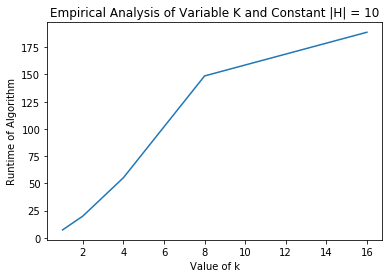

In [18]:
## Empirical Study variables to control.
# Num times of repeat is set across each iteration of k_values
# K_values indicate the different k values we will test
# num_of_hospitals is the fixed |H|
num_times_to_repeat = 5
k_values = [1, 2, 4, 8, 16]
results = [0] * len(k_values)
num_of_hospitals = 10

### Variable to store the file with correct label and title
file_to_store = "Variable_K_Analysis.png"
x_lab = "Value of k"
title = "Empirical Analysis of Variable K and Constant |H| = " + str(num_of_hospitals)

### For each k_value, the experiment is run num_times_to_repeat with randomly sample num_of_hospitals each time
for idx, k in enumerate(k_values):
    total_run_time_k = 0
    for i in range(num_times_to_repeat):
        test_graph = KNearestTargetGraph(graph)
        print(f"Currently on k-value:{k}, Iteration:{i+1}")
        hospitals_to_run = generate_hospital_nodes(test_graph.graph, num_of_hospitals)
        tock = time.time()
        test_graph.bfs(hospitals_to_run, k)
        tick = time.time()
        total_run_time_k += tick - tock
    # Run time is averaged over total time taken for num_times_to_repeat bfs
    results[idx] = total_run_time_k / num_times_to_repeat
    
fig_plot(k_values, [results], title, x_lab, file_store_location = file_to_store)

Currently on number of hospitals:2, Iteration:1
Currently on number of hospitals:2, Iteration:2
Currently on number of hospitals:2, Iteration:3
Currently on number of hospitals:2, Iteration:4
Currently on number of hospitals:2, Iteration:5
Currently on number of hospitals:5, Iteration:1
Currently on number of hospitals:5, Iteration:2
Currently on number of hospitals:5, Iteration:3
Currently on number of hospitals:5, Iteration:4
Currently on number of hospitals:5, Iteration:5
Currently on number of hospitals:10, Iteration:1
Currently on number of hospitals:10, Iteration:2
Currently on number of hospitals:10, Iteration:3
Currently on number of hospitals:10, Iteration:4
Currently on number of hospitals:10, Iteration:5
Currently on number of hospitals:20, Iteration:1
Currently on number of hospitals:20, Iteration:2
Currently on number of hospitals:20, Iteration:3
Currently on number of hospitals:20, Iteration:4
Currently on number of hospitals:20, Iteration:5
Currently on number of hospita

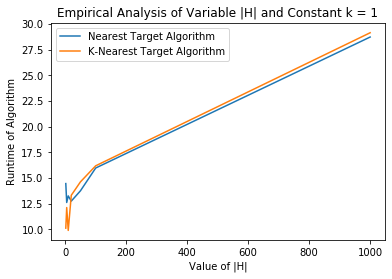

In [19]:
## Empirical Study variables to control.
# Num times of repeat is set across each iteration of k_values
# num_hospital_lists is the number of hospitals we will sample at each iteration
# k indicate the fixed k value we will test on. Set to 1 for quicker computation.
num_times_to_repeat = 5
num_hospital_list = [2,5,10,20,50,100,1000]
results = [0] * len(num_hospital_list)
results_k = results.copy()
k = 1

### Variable to store the file with correct label and title
file_to_store = "Variable_H_Analysis.png"
x_lab = "Value of |H|"
title = "Empirical Analysis of Variable |H| and Constant k = " + str(k)

### For each num_of_hospitals, the experiment is run num_times_to_repeat with randomly sample num_of_hospitals each time.
### This is run over two algorithms to compare their relative time complexity in average case as well.
for idx, num_of_hospitals in enumerate(num_hospital_list):
    total_run_time = 0
    total_run_time_k = 0
    for i in range(num_times_to_repeat):    
        print(f"Currently on number of hospitals:{num_of_hospitals}, Iteration:{i+1}")
        hospitals_to_run = generate_hospital_nodes(test_graph.graph, num_of_hospitals)
        
        test_graph = NearestTargetGraph(graph)
        test_graph_k = KNearestTargetGraph(graph)
        
        tock = time.time()
        test_graph.bfs(hospitals_to_run)
        tick = time.time()
        total_run_time += (tick - tock)
        
        tock = time.time()
        test_graph_k.bfs(hospitals_to_run, k)
        tick = time.time()
        total_run_time_k += (tick - tock)
        
    # Run time is averaged over total time taken for num_times_to_repeat bfs for each algorithm
    results[idx] = total_run_time / num_times_to_repeat
    results_k[idx] = total_run_time_k / num_times_to_repeat
    
fig_plot(num_hospital_list, [results, results_k], title, x_lab, ["Nearest Target Algorithm", "K-Nearest Target Algorithm"], file_store_location = file_to_store)

In [20]:
## Creation of random graph and its pre-allocated randomly generated nodes from a text file to maintain reproducability.

random_graph = read_graph_file("random_graph.txt")
random_graph_hospitals = read_hospital_nodes("random_nodes.txt")
#random_graph_hospitals = generate_hospital_nodes(random_graph, 10)

In [21]:
# Run the first algorithm on the random graph to solve task a) and b) on a random graph network and stores it to a text file.
nearest_target_random_ab = NearestTargetGraph(random_graph)
nearest_target_random_ab.bfs(random_graph_hospitals)

In [22]:
with open("random_taskAB.txt", "w") as f:
    f.writelines("fromNode\tdistance\tpath\n")
    f.writelines(write_to_file_format_a_b(nearest_target_random_ab.path_to_nearest_hospital))

In [23]:
# Run the second algorithm on the random graph to solve task c) on a random graph network and stores it to a text file.

k = 2
k_nearest_target_random_c = KNearestTargetGraph(random_graph)
k_nearest_target_random_c.bfs(random_graph_hospitals, k)

In [24]:
with open(f"random_c_k={k}.txt", "w") as f:
    f.writelines(write_to_file_format_c_d(k_nearest_target_random_c.path_to_nearest_hospital, k))

In [25]:
# Run the second algorithm on the random graph to solve task d) on a random graph network and stores it to a text file.

k = 4

k_nearest_target_random_d = KNearestTargetGraph(random_graph)
k_nearest_target_random_d.bfs(random_graph_hospitals, k)

In [26]:
with open(f"random_d_k={k}.txt", "w") as f:
    f.writelines(write_to_file_format_c_d(k_nearest_target_random_d.path_to_nearest_hospital, k))

In [27]:
# ## User Input: First generate a graph using GraphGenerator.ipynb and input the graph file name in the function read_graph_file
# ## num_nodes is the number of random nodes to generate
# num_nodes = 1


# self_input_graph = read_graph_file("")

# ## Uncomment the type of random node you want to use.
## random_nodes = read_hospital_nodes("")
# random_nodes = generate_hospital_nodes(random_nodes, num_nodes)


## Or you can make a graph from:
# k = 2
# rand_graph = KNearestTargetGraph()
# rand_graph.add_edge(0,3)
# rand_graph.add_edge(3,0)
# rand_graph.add_edge(1,2)
# rand_graph.add_edge(2,1)
# rand_graph.add_edge(1,3)
# rand_graph.add_edge(3,1)
# rand_nodes = generate_hospital_nodes(rand_graph.graph, num_nodes)
# rand_nodes.bfs(random_nodes, k)

# ## Uncomment block to run for tasks a and b
# #graph = NearestTargetGraph(self_input_graph)
# #graph.bfs(random_nodes)

# ## Uncomment block to run for tasks c and d
# #k=2
# #kgraph = KNearestTargetGraph(self_input_graph)
# #kgraph.bfs(random_nodes, k)